# Problem description
This is my take on an introductory Kaggle Competition: https://www.kaggle.com/c/titanic/ <br>
I will be using Keras (on Tenserflow) to solve this problem.<br>

This is binary classification problem, I'll be using binary crossentropy loss function, with sigmoid activation on last network layer. Also data will require some preprocessing before it's usable for Deep Learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras import models
from keras import layers

%matplotlib inline

Using TensorFlow backend.


#### Meet and greet data

In [2]:
train_ds = pd.read_csv('train.csv')
test_ds = pd.read_csv('test.csv')

In [3]:
print(f"Train data shape: {train_ds.shape}")
print(f"Test data shape: {test_ds.shape}")
train_ds.sample(10)

Train data shape: (891, 12)
Test data shape: (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
842,843,1,1,"Serepeca, Miss. Augusta",female,30.0,0,0,113798,31.0000,NaN,C
76,77,0,3,"Staneff, Mr. Ivan",male,NaN,0,0,349208,7.8958,NaN,S
512,513,1,1,"McGough, Mr. James Robert",male,36.0,0,0,PC 17473,26.2875,E25,S
108,109,0,3,"Rekic, Mr. Tido",male,38.0,0,0,349249,7.8958,NaN,S
452,453,0,1,"Foreman, Mr. Benjamin Laventall",male,30.0,0,0,113051,27.7500,C111,C
204,205,1,3,"Cohen, Mr. Gurshon ""Gus""",male,18.0,0,0,A/5 3540,8.0500,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S
532,533,0,3,"Elias, Mr. Joseph Jr",male,17.0,1,1,2690,7.2292,NaN,C
759,760,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.5000,B77,S
477,478,0,3,"Braund, Mr. Lewis Richard",male,29.0,1,0,3460,7.0458,NaN,S


In [4]:
print("          Data summary")
print(train_ds.info())
print('='*40)
print("          NaN values summary")
print("--- Train data: ")
print(train_ds.isnull().sum())
print("--- Test data: ")
print(test_ds.isnull().sum())

          Data summary
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None
          NaN values summary
--- Train data: 
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
--- Test data: 
PassengerId      0
Pclass           0
Name             0
Sex              0
Age     

In [5]:
dataset_cleaner = [train_ds, test_ds]
drop_columns = ['Cabin', 'PassengerId','Ticket']
for dataset in dataset_cleaner:
    dataset.drop(drop_columns, axis = 1, inplace = True)
    dataset['Age'].fillna(dataset['Age'].mean(), inplace = True)
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)

In [6]:
train_ds.isnull().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [7]:
train_ds.sample(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
461,0,3,"Morley, Mr. William",male,34.0,0,0,8.0500,S
348,1,3,"Coutts, Master. William Loch ""William""",male,3.0,1,1,15.9000,S
775,0,3,"Myhrman, Mr. Pehr Fabian Oliver Malkolm",male,18.0,0,0,7.7500,S
499,0,3,"Svensson, Mr. Olof",male,24.0,0,0,7.7958,S
677,1,3,"Turja, Miss. Anna Sofia",female,18.0,0,0,9.8417,S


#### now I need to encode qualitative data for use in neural network

In [8]:
for dataset in dataset_cleaner:
    dataset['Title'] = dataset['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
title_names = (train_ds['Title'].value_counts() < 10)

In [9]:
for dataset in dataset_cleaner:
    dataset['Title'] = dataset['Title'].apply(lambda x: 'Misc' if (x not in title_names) or (title_names.loc[x]) else x)
    dataset.drop(['Name'], axis = 1, inplace = True)

In [10]:
test_ds['Title'].value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Misc        7
Name: Title, dtype: int64

In [11]:
train_ds.sample(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
174,0,1,male,56.000000,0,0,30.6958,C,Mr
481,0,2,male,29.699118,0,0,0.0000,S,Mr
851,0,3,male,74.000000,0,0,7.7750,S,Mr
223,0,3,male,29.699118,0,0,7.8958,S,Mr
797,1,3,female,31.000000,0,0,8.6833,S,Mrs


In [12]:
from sklearn.preprocessing import LabelEncoder

label = LabelEncoder()
for dataset in dataset_cleaner:
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset.drop(['Sex', 'Embarked', 'Title'], axis = 1, inplace = True)

In [20]:
train_data.sample(5)

,Pclass,Age,SibSp,Parch,Fare,Sex_Code,Embarked_Code,Title_Code
546,-0.369158,-0.822881,0.432550,-0.473408,-0.124850,-1.354813,0.585625,1.404829
519,0.826913,0.176964,-0.474279,-0.473408,-0.489167,0.737281,0.585625,0.289229
200,0.826913,-0.130681,-0.474279,-0.473408,-0.456886,0.737281,0.585625,0.289229
710,-1.565228,-0.438326,-0.474279,-0.473408,0.348134,-1.354813,-1.941213,-1.941969
221,-0.369158,-0.207592,-0.474279,-0.473408,-0.386454,0.737281,0.585625,0.289229


In [17]:
train_label = train_ds['Survived']
train_data = train_ds.drop(['Survived'], axis = 1)

dataset_cleaner = [train_data, test_ds]

Let's split data and normalize :)

In [18]:
train_label = train_ds['Survived']

for dataset in dataset_cleaner:
    mean = dataset.mean()
    std = dataset.std()
    dataset -= mean
    dataset /= std

In [63]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(32, activation = 'relu', input_shape = (train_data.shape[1], )))
    model.add(layers.Dense(32, activation = 'relu'))
    model.add(layers.Dense(1, activation = 'sigmoid'))

    model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

We don't really have that much data for training, so let's use K-Fold validation.

In [64]:
k = 4
num_val_samples = train_data.shape[0] // k
num_epochs = 10
all_history = []

for i in range(k):
    print(f"processing fold #{i}")
    val_data = train_data[i*num_val_samples : (i+1)*num_val_samples]
    val_targets = train_label[i*num_val_samples : (i+1)*num_val_samples]
    
    partial_train_data = np.concatenate([train_data[0:i*num_val_samples], train_data[(i+1)*num_val_samples:]], axis = 0)
    partial_train_targets = np.concatenate([train_label[0:i*num_val_samples], train_label[(i+1)*num_val_samples:]], axis = 0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets, epochs = num_epochs, batch_size = 1,
                       validation_data = (val_data, val_targets), verbose = 0)
    all_history.append(history)

processing fold #0
processing fold #1
processing fold #2
processing fold #3


In [65]:
def mean_history(histories, column):
    array = np.array([x.history[column] for x in histories])
    average = np.mean(array, axis = 0)
    return average

average_val_loss = mean_history(all_history, 'val_loss')
average_loss = mean_history(all_history, 'loss')
average_acc = mean_history(all_history, 'acc')
average_val_acc = mean_history(all_history, 'val_acc')

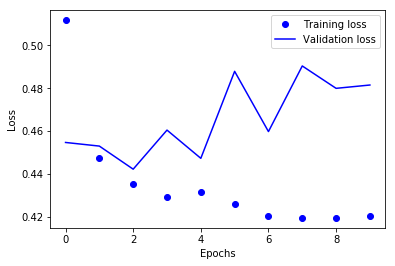

In [66]:
plt.plot(range(num_epochs), average_loss, 'bo', label = 'Training loss')
plt.plot(range(num_epochs), average_val_loss, 'b', label = 'Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

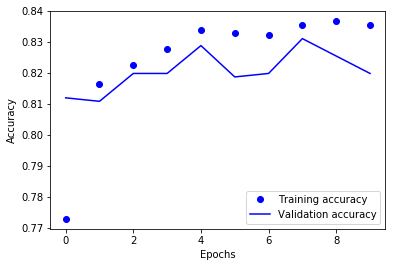

In [67]:
plt.plot(range(num_epochs), average_acc, 'bo', label = 'Training accuracy')
plt.plot(range(num_epochs), average_val_acc, 'b', label = 'Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [68]:
model = build_model()
model.fit(train_data, train_label, epochs = 7, batch_size = 1)
results = model.evaluate(train_data, train_label)
print(results)

Epoch 1/7
891/891 [==============================] - 4s 4ms/step - loss: 0.5058 - acc: 0.7789
Epoch 2/7
891/891 [==============================] - 3s 4ms/step - loss: 0.4427 - acc: 0.8193
Epoch 3/7
891/891 [==============================] - 3s 3ms/step - loss: 0.4407 - acc: 0.8294
Epoch 4/7
891/891 [==============================] - 3s 4ms/step - loss: 0.4328 - acc: 0.8305
Epoch 5/7
891/891 [==============================] - 3s 4ms/step - loss: 0.4490 - acc: 0.8328
Epoch 6/7
891/891 [==============================] - 3s 4ms/step - loss: 0.4320 - acc: 0.8316
Epoch 7/7
891/891 [==============================] - 0s 238us/step
[0.4380133142809809, 0.842873176875473]


In [71]:
result = model.predict(test_ds)
print(result)

[[4.37359177e-02]
 [4.33167398e-01]
 [1.46183418e-02]
 [4.14839573e-02]
 [2.92878777e-01]
 [3.40194926e-02]
 [6.38562441e-01]
 [5.33529259e-02]
 [8.76440465e-01]
 [7.58107519e-03]
 [3.94668430e-02]
 [1.24926269e-01]
 [9.98823822e-01]
 [1.66822784e-02]
 [9.98230994e-01]
 [9.85795856e-01]
 [7.74818733e-02]
 [5.61793819e-02]
 [1.51607409e-01]
 [9.32192147e-01]
 [5.30123822e-02]
 [6.92338228e-01]
 [9.98367131e-01]
 [3.73586029e-01]
 [9.96627986e-01]
 [1.88960470e-02]
 [9.98982131e-01]
 [5.58045805e-02]
 [1.65995106e-01]
 [1.71139836e-02]
 [5.09771705e-02]
 [2.37355530e-02]
 [2.25425020e-01]
 [2.32975990e-01]
 [9.72141549e-02]
 [5.78699075e-02]
 [1.93571031e-01]
 [3.85059178e-01]
 [4.12587561e-02]
 [7.79504925e-02]
 [2.21845061e-02]
 [2.15043068e-01]
 [2.67275292e-02]
 [9.82201636e-01]
 [9.98033702e-01]
 [4.04757075e-02]
 [9.58984047e-02]
 [4.71958145e-02]
 [9.98541236e-01]
 [2.76976079e-01]
 [1.64616585e-01]
 [1.08029641e-01]
 [3.46343875e-01]
 [9.73497868e-01]
 [9.22134370e-02]
 [2.388498